# Samples on Car On Hill

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import jax
import jax.numpy as jnp
import os
import json

parameters = json.load(open("parameters.json"))
env_seed = parameters["env_seed"]
gamma = parameters["gamma"]

# Sample collection
oriented_state = jnp.array(parameters["oriented_state"])
n_random_samples = parameters["n_random_samples"]
n_oriented_samples = parameters["n_oriented_samples"]
n_samples = n_random_samples + n_oriented_samples

# Visualisation of errors and performances
n_states_x = parameters["n_states_x"]
n_states_v = parameters["n_states_v"]
horizon = 100


# keys
sample_key = jax.random.PRNGKey(env_seed)

## Define environment

In [2]:
import numpy as np

from pbo.environments.car_on_hill import CarOnHillEnv


max_pos = 1.0
max_velocity = 3.0

states_x = jnp.linspace(-max_pos, max_pos, n_states_x)
boxes_x_size = (2 * max_pos) / (n_states_x - 1)
states_x_boxes = (np.linspace(-max_pos, max_pos + boxes_x_size, n_states_x + 1) - boxes_x_size / 2)
states_v = jnp.linspace(-max_velocity, max_velocity, n_states_v)
boxes_v_size = (2 * max_velocity) / (n_states_v - 1)
states_v_boxes = (np.linspace(-max_velocity, max_velocity + boxes_v_size, n_states_v + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh and with a uniform policy

In [3]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

env.reset()
n_episodes = 0
n_steps = 0
for idx_sample in range(n_random_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing or n_steps > horizon:
        env.reset()
        n_episodes += 1
        n_steps = 0


env.reset(oriented_state)
n_episodes += 1
n_steps = 0
for idx_sample in range(n_oriented_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing or n_steps > horizon:
        sample_key, key = jax.random.split(sample_key)
        env.reset(jax.random.normal(key, (2,)) / 2 + oriented_state)

        n_episodes += 1
        n_steps = 0

replay_buffer.cast_to_jax_array()
assert sum(replay_buffer.rewards == 1) > 0, "No positive reward has been sampled, please do something!"
print(f"Number of episodes: {n_episodes}")

Number of episodes: 96


In [4]:
replay_buffer.actions[(replay_buffer.rewards == 1).flatten()]

DeviceArray([[1],
             [1],
             [0],
             [1],
             [0],
             [1],
             [0],
             [1],
             [0],
             [0],
             [1],
             [1],
             [0]], dtype=int32)

### Visualize samples

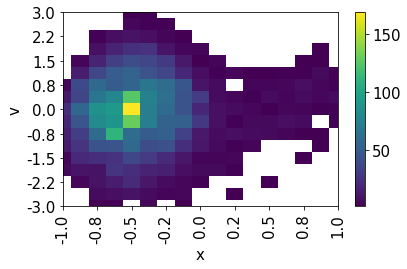

In [5]:
import matplotlib.pyplot as plt

plt.rc("font", size=15)

from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, rewards_count = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    "", xlabel="x", ylabel="v", plot=False, ticks_freq=2
)
_ = plt.savefig(f"figures/samples.pdf", bbox_inches='tight')

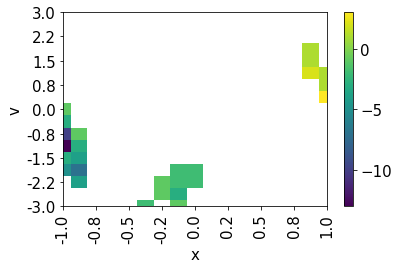

In [6]:
samples_visu_mesh.set_values(rewards_count, zeros_to_nan=True)
samples_visu_mesh.show(
    "", xlabel="x", ylabel="v", plot=False, ticks_freq=2
)
_ = plt.savefig(f"figures/rewards.pdf", bbox_inches='tight')

## Save the data

In [7]:
if not os.path.exists("figures/data/"):
    os.mkdir("figures/data/")
np.save(f"figures/data/samples_count.npy", samples_count)